# Phys201 Final Project Group 5

Author: Thao Dinh, Fan Du, Yiting Huang

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import pandas as pd
import pymc as pm
import scipy.signal as sg
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from matplotlib import rcParams
# import pytesseract as pt
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.gridspec as gs
import math
from importlib import reload
from PIL import Image
import matplotlib as mpl
#import tifffile
from matplotlib.font_manager import FontProperties
from scipy import interpolate 
import pylab as pl  
import seaborn as sns
from pprint import pprint
from numpy import cos, sin, tan, sqrt
from matplotlib.colors import LogNorm
#from tqdm import tqdm
from scipy.optimize import fsolve
from math import sin,cos,e, sqrt
from scipy.optimize import least_squares

In [2]:
# H functions
DEG = np.pi/180
twist = 0

class coor: ### a tuple of 4 int
    def __init__(self, i,j,k,l):
        self.i, self.j, self.k, self.l = i,j,k,l
        self.x = self.i + self.k*cos(twist) - self.l*sin(twist)
        self.y = self.j + self.l*cos(twist) + self.k*sin(twist)
    def __repr__(self):
        return f'({self.i},{self.j},{self.k},{self.l})'
    def __eq__(self, other):
        if (self.i == other.i) and (self.j == other.j) and (self.k == other.k) and (self.l == other.l):
            return True
        else:
            return False
    def __add__(self, o):
        return coor(self.i+o.i, self.j+o.j, self.k+o.k, self.l+o.l)
    def __sub__(self, o):
        return coor(self.i-o.i, self.j-o.j, self.k-o.k, self.l-o.l)
    def __mul__(self, o):
        return coor(self.i*o, self.j*o, self.k*o, self.l*o)
    def __neg__(self):
        return coor(-self.i,- self.j, -self.k, -self.l)
    def __abs__(self):
        return coor(abs(self.i), abs(self.j), abs(self.k), abs(self.l))
        
class coors: ### list of coors
    def __init__(self, coors):
        self.coors = coors
    def __repr__(self):
        return ';'.join([f'({coor.i},{coor.j},{coor.k},{coor.l})' for coor in self.coors])
    def __add__(self, o):
        res = [i+j for i in self.coors for j in o.coors]
        return coors(uniques(res))
    def __sub__(self, o):
        res = [i-j for i in self.coors for j in o.coors]
        return coors(uniques(res))
    def visualize(self, marker='*', color='blue', size=50, alpha=1.0):
        for coor in self.coors:
            x = coor.i + coor.k*cos(twist) - coor.l*sin(twist)
            y = coor.j + coor.l*cos(twist) + coor.k*sin(twist)
            plt.scatter([x],[y],marker=marker, color=color, s=size, alpha=alpha)
            
def uniques(test_list): ### remove duplicates in a list of coors
    res = []
    [res.append(x) for x in test_list if x not in res]
    return res

def slabmode(kx, ky, slope=1.): ### w(kx,ky) of single slab
    return sqrt(kx**2 + ky**2)*slope

def slabmode2(kx, ky, neff=1.573, ratio=0.3): ### The authentic waveguide mode, TM0 mode
    ###ratio = thickness/lattice constant
    k=np.sqrt(kx**2+ky**2)
    def func(k0):
        return neff**2*np.sqrt( k**2-k0**2 ) -  np.sqrt( (neff**2)*(k0)**2-k**2 ) * np.tan(np.sqrt( (neff**2)*(k0)**2-k**2 )*2*np.pi*ratio)
#     result = fsolve(func, k/neff+0.1)
    
    res = least_squares(func, (k/neff+0.000001), bounds = (k/neff,k))
    return res.x[0]

def slabmode3(kx, ky, neff=1.573, ratio=0.3): ### The authentic waveguide mode, TM0 mode
    ###ratio = thickness/lattice constant
    k=np.sqrt(kx**2+ky**2)
    def func(k0):
        return np.sqrt( k**2-k0**2 ) -  np.sqrt( (neff**2)*(k0)**2-k**2 ) * np.tan(np.sqrt( (neff**2)*(k0)**2-k**2 )*2*np.pi*ratio)
#     result = fsolve(func, k/neff+0.1)
    
    res = least_squares(func, (k/neff+0.000001), bounds = (k/neff,k))
    return res.x[0]

def ham1(theta):
    h11, v11, u20, neff, ratio = theta
    kx = 0.05
    ky = 0.0
    ham = np.zeros([Nbases,Nbases],dtype=float) ### potentially complex, if want gain and loss
    ### diagonal freqs
    for i in range(Nbases):
        Gx, Gy = Gbases.coors[i].x, Gbases.coors[i].y
        kxinc=kx-Gx*sin(alpha/2)+Gy*sin(alpha/2)
        kyinc=ky-Gx*cos(alpha/2)-Gy*cos(alpha/2)
        ham[i,i] = slabmode2(kxinc,kyinc,neff,ratio)
    ### off-diagonal coupling

    criteria_h11 = [G1x-G1y,-G1x+G1y]
    criteria_v11 = [G1x+G1y,-G1x-G1y]
    criteria_u20 = [G1x*2,G1y*2]
    
    #### fill in the entries
    for i in range(Nbases):
        for j in range(i+1,Nbases):
            G1 = Gbases.coors[i]
            G2 = Gbases.coors[j]   

            if abs(G2-G1) in criteria_u20:
                # print(U20)
                ham[i,j] = u20
                ham[j,i] = u20
                continue

            if (G2-G1) in criteria_h11:
                # print(U10)
                ham[i,j] = h11
                ham[j,i] = h11
                continue

            if (G2-G1) in criteria_v11:
                # print(U10)
                ham[i,j] = v11
                ham[j,i] = v11
                continue
    eigs = np.linalg.eigvals(ham)
    
    gm_vflatten=np.array(eksM_tm).flatten()
    #gx_vflatten=np.array(eksX_tm)
    Cn=np.real(eigs)
    return Cn

Origin = coor(0,0,0,0)
G1x = coor(1,0,0,0)
G1y = coor(0,1,0,0)
G2x = coor(0,0,1,0)
G2y = coor(0,0,0,1)
# G1s = coors([G1x, -G1x, G1y, -G1y])
G1s = coors([G1y, G1x, -G1y, -G1x])

Gbases = coors(uniques(G1s.coors))
Nbases = len(Gbases.coors) ### num of bases
print(Nbases)
 

4


[ 29.799      104.84833333]


<ErrorbarContainer object of 3 artists>

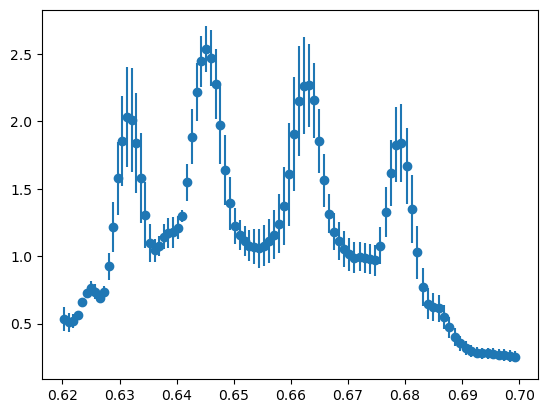

In [3]:
# load processed data from npy
exp_data0 = np.load('expdata_GM0.05.npy')
#
a = 1000e-9  # lattice constant of phc
c = 299792458
normf0 = exp_data0[0]*1e12*a/c

y_cut = [0.62,0.7]
cut = len(normf0)*(y_cut-np.min(normf0))/(np.max(normf0)-np.min(normf0))
normf = normf0[(normf0 > y_cut[0]) & (normf0 <  y_cut[1])]
print(cut)
#exp_data = exp_data0[:,int(cut[0]):int(cut[1])]
frequency = exp_data0[0][(normf0 > y_cut[0]) & (normf0 <  y_cut[1])]
normf = frequency*1e12*a/c
y = exp_data0[1][(normf0 > y_cut[0]) & (normf0 <  y_cut[1])]
sigmay = exp_data0[2][(normf0 > y_cut[0]) & (normf0 <  y_cut[1])]

plt.errorbar(normf,y,sigmay,fmt='o')


[0.66431403 0.65239414 0.63114237 0.62306226]


<Figure size 640x480 with 0 Axes>

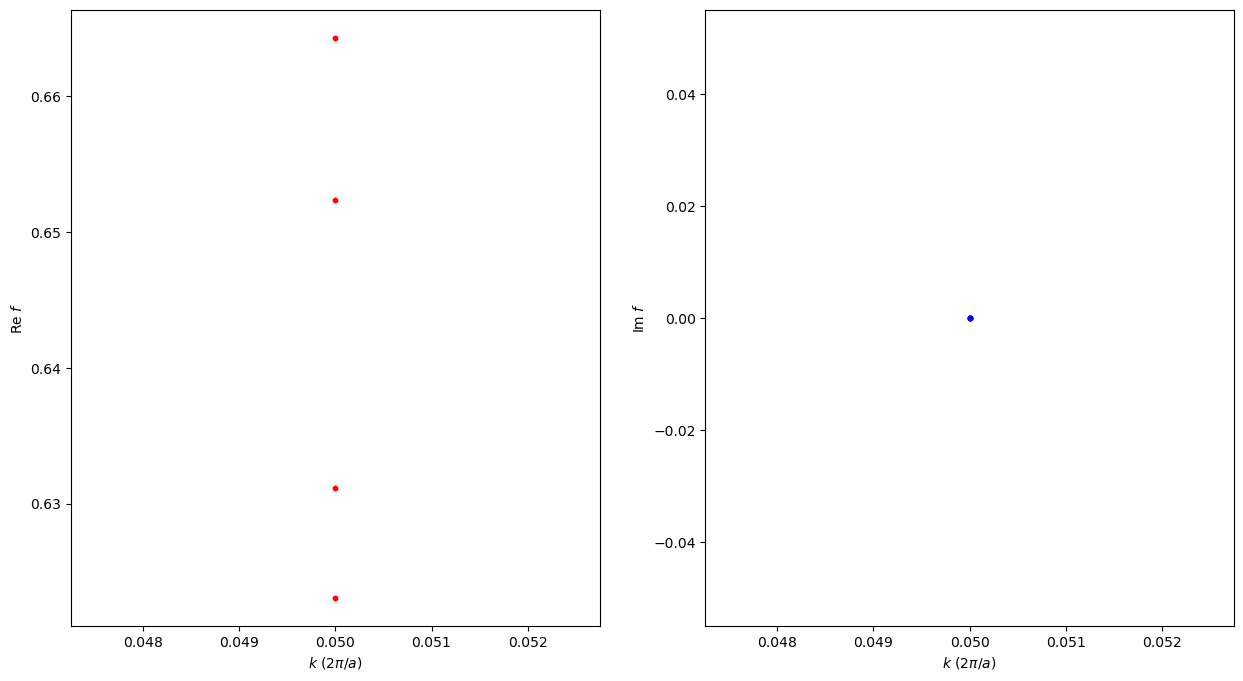

[0.66431403 0.65239414 0.63114237 0.62306226]


In [4]:
lim=0.3
Nk=1
knorm =np.array([0.05])
GM_kx=knorm*np.cos(twist/2+np.pi/4)
GM_ky=knorm*np.sin(twist/2+np.pi/4)
GX_kx=knorm*np.cos(twist/2)
GX_ky=knorm*np.sin(twist/2)
eksM_tm = [] ### diagonal entries
eksX_tm = []
eksM_te = [] ### diagonal entries
eksX_te = []

constant_c=299792458
lim=0.1

alpha=90*DEG

h11=0.005
v11=h11
u20=0.003

decay=0.00
neff=2.1
ratio=0.23  #0.152


#for i in range(Nk):
i = 0
lr=np.array([ [1,cos(alpha),-1,-cos(alpha)],[cos(alpha),1,-cos(alpha),-1],[-1,-cos(alpha),1,cos(alpha)],[-cos(alpha),-1,cos(alpha),1]]) *decay*1j
# 
# GX_kx[i],GX_ky[i],  
eksX_tm=ham1([h11, v11, u20, neff, ratio])   # (0.05, 0 )is the k point we chose
knorm_flattern=np.repeat(knorm,4)
gx_vflatten=np.array(eksX_tm).flatten()
print(gx_vflatten)

#===================================================================================================
asp=0.6/30

plt.figure()
fig, axx=plt.subplots(1,2,figsize=(15,8))

ax=axx[0]
#ax.plot(knorm,np.real(eksX_tm),'-',c='r',alpha=0.5)
#ax.plot(-knorm,np.real(eksM_tm),'-',c='r',alpha=0.5)
ax.scatter(knorm_flattern,np.real(gx_vflatten),s=10,color='red')
#ax.scatter(-knorm_flattern,np.real(gx_vflatten),s=10,color='red')


ax.set_xlabel('$k \ (2\pi/a)$')
ax.set_ylabel('Re $f$ ')
# ax.set_ylim([0.8,1])
#ax.set_ylim([0.85,0.925])
#ax.set_xlim([-lim,lim])

ax=axx[1]
ax.scatter(knorm_flattern,np.imag(gx_vflatten),s=10,color='blue')
#ax.scatter(-knorm_flattern,np.imag(gx_vflatten),s=10,color='blue')

ax.set_xlabel('$k \ (2\pi/a)$')
ax.set_ylabel('Im $f$ ')
#ax.set_xlim([-lim,lim])
# fig.subplots_adjust(wspace=0.2,hspace=0.0)

# plt.tick_params(labelsize=28)  
plt.show() 
print(np.real(gx_vflatten))

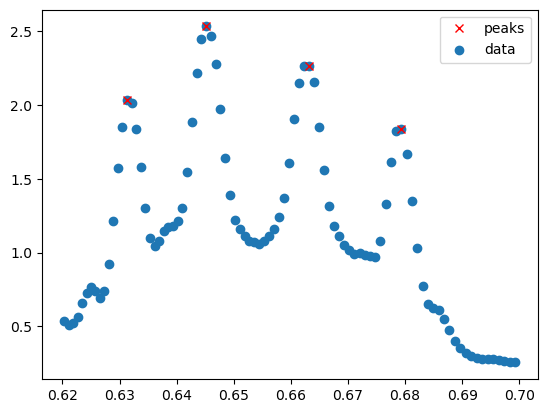

In [5]:
# parameters to infer  h11=h11, v11=v11, u20=u20, neff=neff, ratio=ratio
# find peaks as initial value
peaks, _ = sg.find_peaks(y, height=1.8, distance=1,width = 1.5)

chose_peak = np.vstack((y[peaks],normf[peaks])).T
indices = np.argsort(chose_peak[:, 0])[::-1]
chose_peak = chose_peak[indices]
# print(chose_peak)
plt.plot(chose_peak[:,1], chose_peak[:,0], "x",c = 'r',label = 'peaks')
plt.scatter(normf,y,label = 'data');
plt.legend()

In [6]:
from pytensor import tensor as pt
class peak_position(pt.Op):
    """
    Specify what type of object will be passed and returned to the Op when it is
    called.
    """
    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dvector]  # outputs a vector of peak positions

    def __init__(self, Hamiltonian):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        Hamiltonian:
            The Hamiltonian function we've defined
        """
        # add inputs as class attributes
        self.ham = Hamiltonian #your Hamiltonian function goes in here

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain all variables of the Hamiltonian function
        # call the hamiltonian function
        pos = self.ham(theta)
        outputs[0][0] = np.array(pos)  # output the eigenvalues

In [7]:
n = 4 # fit four peaks
# set up the model
peak = peak_position(ham1)
peaks_model = pm.Model()
with peaks_model:
    # Priors for unknown model parameters
    An = pm.Uniform("w", 1.5, 3.0, shape = n, transform = None)
    h11 = pm.Uniform('h11',0.001,0.01, transform = None)
    v11 = pm.Uniform('v11',0.001,0.01, transform = None)
    u20 = pm.Uniform('u20',0.001,0.005, transform = None)
    neff = pm.Uniform('neff',2.0,2.2, transform = None)
    ratio = pm.Uniform('ratio',0.2,0.4, transform = None)
    sigma_L = pm.Uniform('peak_width',1e-3,1e-2, transform = None)
    
    theta = pt.as_tensor_variable([h11,v11,u20,neff,ratio])
    Cn = pm.Deterministic('peak_pos', peak(theta)) #calculate the peak position from others variables
    

    line = pm.NormalMixture('line', w = An, mu = Cn, sigma = sigma_L) #spectral line model

    # Likelihood of observations
    measurements = pm.Normal('norm_frequency', mu=line, sigma=sigmay, observed=y)
best_fit, scipy_output = pm.find_MAP(model=peaks_model, return_raw=True)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'w': array([2.25, 2.25, 2.25, 2.25]), 'h11': array(0.0055), 'v11': array(0.0055), 'u20': array(0.003), 'neff': array(2.1), 'ratio': array(0.3), 'peak_width': array(0.0055), 'line': array(5.30027305)}

Initial evaluation results:
{'w': -1.62, 'h11': 4.71, 'v11': 4.71, 'u20': 5.52, 'neff': 1.61, 'ratio': 1.61, 'peak_width': 4.71, 'line': -inf, 'norm_frequency': -233242.89}

In [ ]:
import arviz as az

with peaks_model:
    idata = pm.sample(500)
    az.plot_trace(idata)